In [28]:
from collections import namedtuple
import os
import random
import time

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import scipy.stats
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, Matern
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import tqdm

from neuralprocesses import split_context_target, NeuralProcessParams
from neuralprocesses import network
from neuralprocesses import loss
from neuralprocesses import predict
from neuralprocesses import process

tf.get_logger().setLevel('ERROR')

ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_samples(xs, sample_ys, xlim=(-1.0, 1.0), ax=None, c=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))
    if c is None:
        c = ccycle[0]
    n_samples = sample_ys.shape[1]
    for i in range(n_samples):
        ax.plot(xs, sample_ys[:,i], c=c, alpha=15.0 / n_samples)
    return ax

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


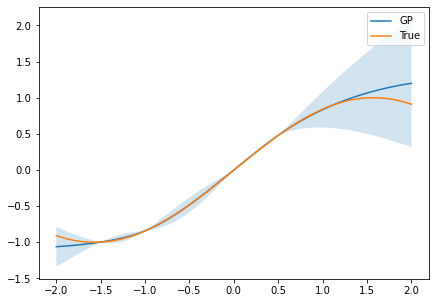

In [29]:
# playing around with the Gaussian Processes package

x_space = np.linspace(-2, 2, 100).reshape(-1, 1)

x_c = np.array([-1.5, -1, 0, 0.2, 0.5]).reshape(-1, 1)
y_c = np.sin(x_c)

kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)

gp_model = GaussianProcessRegressor(kernel=kernel, random_state=0)
gp_model.fit(x_c, y_c)

y_t, std = gp_model.predict(x_space, return_std=True)

y_t = y_t.reshape(-1)

fig, ax = plt.subplots()
ax.plot(x_space, y_t, label = "GP")
ax.fill_between(x_space.reshape(-1), y_t - 1.96*std, y_t + 1.96*std, "r", label = "_nolegend_", alpha = 0.2)
ax.plot(x_space, np.sin(x_space), label = "True")
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(7)

In [30]:
#functions used below:

def draw_gp_path(x, mean_fn, kernel):
    """
    Takes as input:
    x - the points we want to evaluate
    mean_fn - the mean function of the GP
    kernel - the kernel function of the GP

    returns:
    A random gp draw evaluated at the points in x
    """
    K = kernel(x)
    mu = mean_fn(x)

    return scipy.stats.multivariate_normal.rvs(mean = mu, cov = K, size = 1)

# next two functions are for plotting
def update_k(x_new, x_c, kernel):
    """
    This function returns the posterior standard deviation of a GP

    Takes as input: 
    x_new - points we want to evaluate the new kernel at
    x_c - points we have already evaluated
    kernel - the kernel of the prior

    returns:
    The standard deviation of the posterior at the points x_new
    """
    K = kernel(x_c)
    inv_K = np.linalg.inv(K)

    n = len(x_new)

    out = np.zeros(n)

    for i in range(n):
        kx = kernel(x_c, x_new[i].reshape(-1, 1))
        out[i] = np.dot(kx.T, np.dot(inv_K, kx))
    
    k_xx = kernel.diag(x_new)

    return (k_xx - out)

def update_mean(x_new, x_c, y_c, mean_fn, kernel):
    """
    This function returns the posterior standard deviation of a GP

    Takes as input: 
    x_new - points we want to evaluate the new kernel at
    x_c - points we have already evaluated
    y_c - observed points
    mean_fn - prior mean function
    kernel - the kernel of the prior

    returns:
    The mean of the posterior at the points x_new
    """

    K = kernel(x_c.reshape(-1, 1))
    inv_K = np.linalg.inv(K)

    n = len(x_new)

    out = np.zeros(n)

    y_m = y_c - mean_fn(x_c).reshape(-1, 1)

    for i in range(n):
        kx = kernel(x_c, x_new[i].reshape(-1, 1))
        out[i] = np.dot(kx.T, np.dot(inv_K, y_m))

    return mean_fn(x_new).reshape(-1) + out.reshape(-1)


def draw_gp_post(x, x_c, mean_fn, kernel_fn):
    """
    This function returns the a sample from a posterior GP

    Takes as input: 
    x - points we want to evaluate the GP at
    x_c - points we have already evaluated
    mean_fn - mean of the POSTERIOR
    kernel_fn - kernel of the PRIOR

    returns:
    A draw from the posterior GP evaluated at x
    """
    K = kernel(x_c)
    invK = np.linalg.inv(K)
    Kx = kernel(x_c, x)
    Kxx = kernel(x)

    K = Kxx - np.dot(Kx.T, np.dot(invK, Kx))

    mu = mean_fn(x)

    return scipy.stats.multivariate_normal.rvs(mean = mu, cov = K, size = 1)

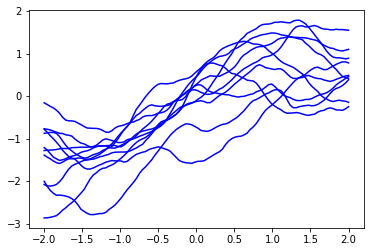

In [31]:
#example of draws from a GP
kernel = 0.5 * Matern(length_scale=1, nu=1.5)

fig, ax = plt.subplots()

func = lambda x: np.sin(x.reshape(-1))

for i in range(0, 10):
    ax.plot(x_space, draw_gp_path(x_space, func, kernel), "b")

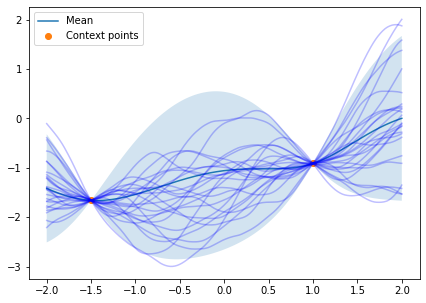

In [32]:
# example of draws from a posterior GP
kernel = 1 * Matern(length_scale=1, nu = 2.5)

x_c = np.array([-1.5, 1]).reshape(-1, 1) # choose context set

y_c = draw_gp_path(x_c, func, kernel).reshape(-1, 1) # draw y's

# plot posterior mean and bouns
x_space = np.linspace(-2, 2, 300).reshape(-1, 1)

mean = update_mean(x_space, x_c, y_c, func, kernel)
std = np.sqrt(update_k(x_space, x_c, kernel))

fig, ax = plt.subplots()
ax.plot(x_space, mean, label = "Mean")
ax.fill_between(x_space.reshape(-1), mean - 1.96*std, mean + 1.96*std, "r", label = "_nolegend_", alpha = 0.2)
ax.scatter(x_c, y_c, label = "Context points")
ax.legend()

fig.set_figheight(5)
fig.set_figwidth(7)

# define posterior mean function
func_2 = lambda x: update_mean(x, x_c, y_c, func, kernel)

# plot draws from posterior
for i in range(0, 25):
    ax.plot(x_space, draw_gp_post(x_space, x_c, func_2, kernel), "b", alpha = 0.25)

In [33]:
# this was not used, but I'm scacred to delete it
def data_generator_gp(n_iter, kernel, mean_fn):
    for i in range(n_iter):
        # Select 20 random observations from a sinoid with a random amplitude
        n_obs = 20
        xs = np.random.uniform(-2, 2, n_obs).reshape([-1, 1]).astype(np.float32)
        ys = draw_gp_path(xs, func, kernel).reshape(-1,1).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)
        yield context_xs, context_ys, target_xs, target_ys

kernel = 0.7 * Matern(length_scale=1, nu = 3.5)
func = lambda x: np.sin(x.reshape(-1))

ds = tf.data.Dataset.from_generator(lambda: data_generator_gp(100, kernel, func), output_types=(tf.float32, tf.float32, tf.float32, tf.float32))

In [34]:
from neuralprocesses.loss import loglikelihood, kullback_leibler_gaussian

In [302]:
#Training an NP on GP class of functions
kernel = 0.75 * Matern(length_scale=1, nu = 2.5) # GP kernel
func = lambda x: np.sin(x.reshape(-1))# GP mean function

#Set up NN
params = NeuralProcessParams(
    dim_x= 1,
    dim_y= 1,
    dim_r = 8,
    dim_z= 4,
    n_hidden_units_h=[16, 16, 16],
    n_hidden_units_g=[16, 16, 16]
)

#neurproc = process.NeuralProcess(params)

# Strain settings
n_epochs = 600
n_iter = 100
n_train_draws = 100
n_test_draws = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-14)
train_loss = tf.keras.metrics.Mean(name='train_loss')

e_num = 0

for e in tqdm(range(n_epochs), desc="Training epochs"):

    train_loss.reset_states()

    zs = []
    for i in range(n_iter):
        # Select 20 random observations from a GP
        n_obs = 20
        xs = np.random.uniform(-2, 2, n_obs).reshape([-1, 1]).astype(np.float32)
        ys = draw_gp_path(xs, func, kernel).reshape([-1,1]).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 10))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)

        with tf.GradientTape() as tape:
            pred_ys_mu, z_mu, z_sigma, z_mu_ct, z_sigma_ct = neurproc(
                [context_xs], [context_ys], [target_xs], [target_ys], n_draws=n_train_draws
            )

            loglike_loss = tf.negative(loglikelihood(target_ys, pred_ys_mu))
            kl_loss = kullback_leibler_gaussian(z_mu, z_sigma, z_mu_ct, z_sigma_ct)
            loss = loglike_loss + kl_loss

        zs.append(z_mu.numpy())
        gradients = tape.gradient(loss, neurproc.trainable_variables)
        optimizer.apply_gradients(zip(gradients, neurproc.trainable_variables))

        train_loss(loss)
    
    print(f"Loss: {train_loss.result()}")
    
    e_num = e_num + 1

    #if e_num == 10:
    #    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    #if e_num == 200:
    #    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    #    kernel = 0.4 * Matern(length_scale=1, nu = 2.5)

    #if e_num == 450:
    #    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    #    kernel = 0.75 * Matern(length_scale=1, nu = 2.5)
    
    #if e_num == 1000:
    #    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

Loss: 44.52703094482422
Loss: 44.05735778808594
Loss: 44.2006950378418
Loss: 37.763824462890625
Loss: 44.82265090942383
Loss: 49.1870231628418
Loss: 43.739036560058594
Loss: 42.24998474121094
Loss: 43.19126892089844
Loss: 47.432159423828125
Loss: 44.97414016723633
Loss: 43.76491165161133
Loss: 40.554779052734375
Loss: 48.88090515136719
Loss: 39.74009323120117
Loss: 45.015167236328125
Loss: 41.12059020996094
Loss: 47.692726135253906
Loss: 46.76426696777344
Loss: 39.963783264160156
Loss: 46.60211944580078
Loss: 43.455814361572266
Loss: 48.913814544677734
Loss: 39.75285339355469
Loss: 43.493499755859375
Loss: 42.160823822021484
Loss: 44.5044059753418
Loss: 45.456111907958984
Loss: 38.60719299316406
Loss: 33.66105651855469
Loss: 36.255592346191406
Loss: 44.99751281738281
Loss: 49.400203704833984
Loss: 45.137901306152344
Loss: 47.59901428222656
Loss: 47.27096176147461
Loss: 40.4609489440918
Loss: 49.86326217651367
Loss: 49.45849609375
Loss: 40.96690368652344
Loss: 39.75746154785156
Loss: 44

KeyboardInterrupt: 

[ 0.29943917 -1.89076187  1.53300728  0.9036739  -1.87436201 -0.48851695
 -1.05445451  1.91884334  0.73916253]
[ 0.395047   -2.1134744   1.6578252   1.4402041  -2.1080391  -0.35542804
 -1.4727535   0.7060092   1.2121474 ]


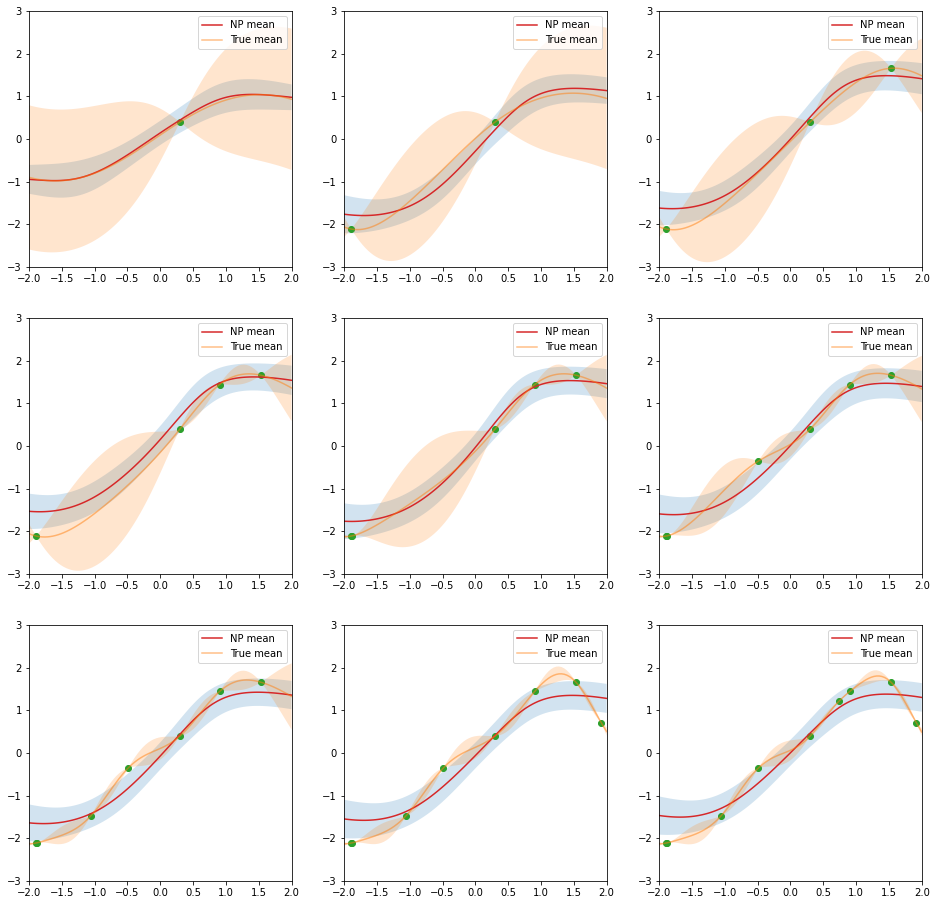

In [489]:
def plot_prediction(ax, context_xs, context_ys, func, kernel):
    input_xs= np.linspace(-2, 2, 100)
    pred_ys, z_mu, z_sigma = neurproc(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()

    mean = update_mean(input_xs.reshape(-1,1), context_xs.reshape(-1,1), context_ys.reshape(-1,1), func, kernel)
    std = np.sqrt(update_k(input_xs.reshape(-1,1), context_xs.reshape(-1,1), kernel))
    func_2 = lambda x: update_mean(input_xs.reshape(-1, 1), context_xs.reshape(-1, 1), context_ys.reshape(-1, 1), func, kernel)
    
    #for i in range(pred_ys.shape[0]):
    #    ax.plot(input_xs, pred_ys[i], c=ccycle[3], alpha=0.1)
        #ax.plot(input_xs, draw_gp_post(input_xs.reshape(-1, 1), context_xs.reshape(-1, 1), func_2, kernel), "b", alpha = 0.1)

    M = np.mean(pred_ys, axis = 0)
    S = np.std(pred_ys, axis = 0)

    ax.plot(input_xs, M, c=ccycle[3], label = "NP mean")
    ax.fill_between(input_xs.reshape(-1), M - 1.96*S, M + 1.96*S, "r", label = "_nolegend_", alpha = 0.2)

    ax.plot(input_xs, mean, c=ccycle[1], alpha=.5, label = "True mean")
    ax.fill_between(input_xs.reshape(-1), mean - 1.96*std, mean + 1.96*std, "r", label = "_nolegend_", alpha = 0.2)
    ax.scatter(context_xs, context_ys, c=ccycle[2])
    ax.set_xlim((-2, 2))
    ax.set_ylim((-3, 3))
    ax.vlines(-3, -1.5, 1.5, alpha=.2)
    ax.vlines(3, -1.5, 1.5, alpha=.2)
    ax.legend()

func = lambda x: np.sin(x).reshape(-1)

max_n_context = 9
fig, axes = plt.subplots(3, 3, figsize=(16,16))
all_context_xs = np.random.uniform(-2, 2, max_n_context)
#all_context_xs = np.array([-1.9, -1.2, -.3, .7, 1.5])
print(all_context_xs)
all_context_ys = draw_gp_path(all_context_xs.reshape(-1, 1), func, kernel).reshape(-1).astype(np.float32)
print(all_context_ys)
for i in range(9):
    n_context = i + 1
    context_xs = all_context_xs[:n_context]
    context_ys = all_context_ys[:n_context]
    ax = axes[i // 3, i % 3]
    plot_prediction(ax, context_xs, context_ys, func, kernel)

In [534]:
context_xs = np.array([-1.20304644, 0.27894081, -1.15851547, 0.9044811, 0.31660761, 1.64172645, -0.94970004, 1.37219223, -1.57609309])

context_ys = np.array([-2.1213126, -1.4015505, -2.009782, -0.58176535, -1.3700659, 1.2355108, -1.5245641, 0.7119917, -2.841078])

input_xs = np.linspace(-2, 2, 200)

M = np.zeros((5, len(input_xs)))
S = np.zeros((5, len(input_xs)))

for i in range(0, 5):
    if i == 4:
        i = 7

    context_xs = all_context_xs[:i+1]
    context_ys = all_context_ys[:i+1]
    pred_ys, z_mu, z_sigma = neurproc(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()

    if i == 7:
        i = 4

    Ms = np.mean(pred_ys, axis = 0).reshape(-1)
    Ss = np.std(pred_ys, axis = 0).reshape(-1)

    M[i,:] = Ms
    S[i, :] = Ss

Text(0.5, 0, 'x')

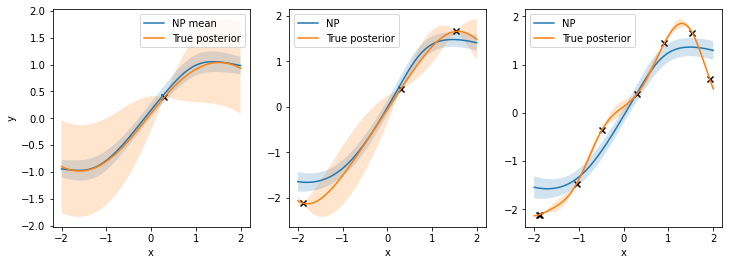

In [550]:
func = lambda x: np.sin(x).reshape(-1)
kernel = 0.75 * Matern(length_scale=1, nu = 2.5)

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(19.20,10.80))
fig.set_figwidth(12)
fig.set_figheight(4)

mean1 = update_mean(input_xs.reshape(-1,1), context_xs[:1].reshape(-1,1), context_ys[:1].reshape(-1,1), func, kernel)
std1 = np.sqrt(update_k(input_xs.reshape(-1,1), context_xs[:1].reshape(-1,1), kernel))

mean2 = update_mean(input_xs.reshape(-1,1), context_xs[:3].reshape(-1,1), context_ys[:3].reshape(-1,1), func, kernel)
std2 = np.sqrt(update_k(input_xs.reshape(-1,1), context_xs[:3].reshape(-1,1), kernel))

mean3 = update_mean(input_xs.reshape(-1,1), context_xs.reshape(-1,1), context_ys.reshape(-1,1), func, kernel)
std3 = np.sqrt(update_k(input_xs.reshape(-1,1), context_xs.reshape(-1,1), kernel))

ax[0].plot(input_xs, M[0, :], label = "NP mean")
ax[0].fill_between(input_xs.reshape(-1), M[0, :] - S[0, :], M[0,:]+S[0, :], "b", label = "_nolegend_", alpha = 0.2)
ax[0].plot(input_xs, mean1, label = "True posterior")
ax[0].fill_between(input_xs.reshape(-1), mean1 - std1, mean1 + std1, "b", label = "_nolegend_", alpha = 0.2)
ax[0].scatter(context_xs[:1], context_ys[:1], marker = "x", color = "k")
ax[0].legend()
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].plot(input_xs, M[2, :], label = "NP")
ax[1].fill_between(input_xs.reshape(-1), M[2, :] - S[2, :], M[2,:] + S[2, :], "b", label = "_nolegend_", alpha = 0.2)
ax[1].plot(input_xs, mean2, label = "True posterior")
ax[1].fill_between(input_xs.reshape(-1), mean2 - std2, mean2 + std2, "b", label = "_nolegend_", alpha = 0.2)
ax[1].scatter(context_xs[:3], context_ys[:3], marker = "x", color = "k")
ax[1].legend()
ax[1].set_xlabel("x")

ax[2].plot(input_xs, M[4, :], label = "NP")
ax[2].fill_between(input_xs.reshape(-1), M[4, :] - S[4, :], M[4,:] + S[4, :], "b", label = "_nolegend_", alpha = 0.2)
ax[2].plot(input_xs, mean3, label = "True posterior")
ax[2].fill_between(input_xs.reshape(-1), mean3 - std3, mean3 + std3, "b", label = "_nolegend_", alpha = 0.2)
ax[2].scatter(context_xs, context_ys, marker = "x", color = "k")
ax[2].legend()
ax[2].set_xlabel("x")

In [520]:
std2

array([0.12024243, 0.09837323, 0.07634674, 0.05419768, 0.03196361,
       0.00968509, 0.01259419, 0.03482882, 0.05697539, 0.07899352,
       0.10084568, 0.12249708, 0.14391559, 0.16507153, 0.18593764,
       0.20648892, 0.22670254, 0.24655773, 0.26603565, 0.28511931,
       0.30379346, 0.3220445 , 0.33986036, 0.35723042, 0.37414542,
       0.39059735, 0.4065794 , 0.42208582, 0.43711189, 0.45165382,
       0.46570864, 0.4792742 , 0.49234902, 0.50493229, 0.51702374,
       0.52862364, 0.5397327 , 0.55035201, 0.56048302, 0.57012746,
       0.57928731, 0.58796472, 0.59616203, 0.60388165, 0.61112609,
       0.6178979 , 0.62419961, 0.63003374, 0.63540277, 0.64030906,
       0.6447549 , 0.64874244, 0.65227369, 0.6553505 , 0.65797452,
       0.66014725, 0.66186995, 0.6631437 , 0.66396935, 0.66434752,
       0.66427862, 0.66376285, 0.66280015, 0.66139028, 0.65953277,
       0.65722693, 0.6544719 , 0.65126662, 0.64760987, 0.64350028,
       0.63893634, 0.63391641, 0.62843878, 0.62250167, 0.61610

In [433]:
np.save("gp_sin_np_mean", M)
np.save("gp_sin_np_sd", S)

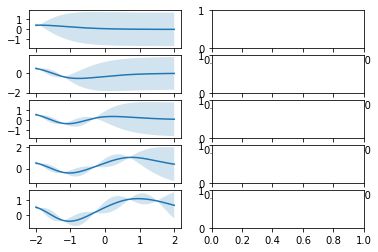

In [327]:
context_xs = np.array([-1.9, -1.2, -0.3, 0.7, 1.5])
context_ys = np.array([0.4264, -0.3638, 0.1630, 1.0264, 0.9203])

input_xs = np.linspace(-2, 2, 200)

func = lambda x: np.zeros(len(x))
kernel = 0.75 * Matern(length_scale=1, nu = 2.5) 

mean = update_mean(input_xs.reshape(-1,1), context_xs.reshape(-1,1), context_ys.reshape(-1,1), func, kernel)
std = np.sqrt(update_k(input_xs.reshape(-1,1), context_xs.reshape(-1,1), kernel))

fig, ax = plt.subplots(5, 2)
#ax.plot(input_xs, mean, c=ccycle[1], alpha=.5, label = "True mean")
#ax.fill_between(input_xs.reshape(-1), mean - 1.96*std, mean + 1.96*std, "r", label = "_nolegend_", alpha = 0.2)

M = np.zeros((5, len(input_xs)))
S = np.zeros((5, len(input_xs)))

for i in range(0, 5):
    mean = update_mean(input_xs.reshape(-1,1), context_xs[:i+1].reshape(-1,1), context_ys[:i+1].reshape(-1,1), func, kernel)
    std = np.sqrt(update_k(input_xs.reshape(-1,1), context_xs[:i+1].reshape(-1,1), kernel))
    ax[i, 0].plot(input_xs, mean)
    ax[i, 0].fill_between(input_xs.reshape(-1), mean - 1.96*std, mean + 1.96*std, "r", label = "_nolegend_", alpha = 0.2)
    M[i,:] = mean
    S[i, :] = std

In [329]:
np.save("GPs_true_mean", M)
np.save("GPs_true_sd", S)

In [80]:
# Training on polynomial example

#Set up NN
params = NeuralProcessParams(
    dim_x=1,
    dim_y=1,
    dim_r=8,
    dim_z=4,
    n_hidden_units_h=[16, 16, 16],
    n_hidden_units_g=[16, 16, 16]
)

neurproc = process.NeuralProcess(params)

# Strain settings
n_epochs = 500
n_iter = 100
n_train_draws = 50
n_test_draws = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
train_loss = tf.keras.metrics.Mean(name='train_loss')

e_num = 0

for e in tqdm(range(n_epochs), desc="Training epochs"):

    train_loss.reset_states()

    zs = []
    for i in range(n_iter):
        # Select 20 random observations from a GP
        n_obs = 20
        xs = np.random.uniform(-1, 1, n_obs).reshape([-1, 1]).astype(np.float32)
        #amp = random.uniform(-2, 2)
        #ys = (amp * np.sin(xs)).astype(np.float32)
        A = np.random.uniform(low = 1, high = 10)
        B = np.random.poisson(lam = 1)
        ys = (A*xs**(2*B+1)).reshape([-1,1]).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)

        with tf.GradientTape() as tape:
            pred_ys_mu, z_mu, z_sigma, z_mu_ct, z_sigma_ct = neurproc(
                [context_xs], [context_ys], [target_xs], [target_ys], n_draws=n_train_draws
            )

            loglike_loss = tf.negative(loglikelihood(target_ys, pred_ys_mu))
            kl_loss = kullback_leibler_gaussian(z_mu, z_sigma, z_mu_ct, z_sigma_ct)
            loss = loglike_loss + kl_loss

        zs.append(z_mu.numpy())
        gradients = tape.gradient(loss, neurproc.trainable_variables)
        optimizer.apply_gradients(zip(gradients, neurproc.trainable_variables))

        train_loss(loss)
    
    print(f"Loss: {train_loss.result()}")

    e_num = e_num + 1
    if e_num == 150:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    e_num = e_num + 1
    if e_num == 400:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)

Loss: 40.678035736083984
Loss: 39.74016571044922
Loss: 42.43159484863281
Loss: 69.60204315185547
Loss: 67.42532348632812
Loss: 45.22504806518555
Loss: 46.96709060668945
Loss: 36.53878402709961
Loss: 46.04755783081055
Loss: 66.83177947998047
Loss: 50.36427688598633
Loss: 46.08590316772461
Loss: 55.732540130615234
Loss: 45.81185531616211
Loss: 37.429805755615234
Loss: 55.63642501831055
Loss: 50.36457824707031
Loss: 52.46939468383789
Loss: 35.873443603515625
Loss: 48.2584114074707
Loss: 46.13260269165039
Loss: 56.32080078125
Loss: 32.26447677612305
Loss: 52.541011810302734
Loss: 33.798954010009766
Loss: 52.81410217285156
Loss: 48.9144172668457
Loss: 44.789913177490234
Loss: 34.8159065246582
Loss: 48.919029235839844
Loss: 42.659305572509766
Loss: 41.802154541015625
Loss: 75.96754455566406
Loss: 63.41477584838867
Loss: 34.75651931762695
Loss: 45.85004425048828
Loss: 44.499855041503906
Loss: 50.594913482666016
Loss: 39.806732177734375
Loss: 46.846290588378906
Loss: 49.929534912109375
Loss: 4

In [380]:
# Training on exponential example

#Set up NN
params = NeuralProcessParams(
    dim_x=1,
    dim_y=1,
    dim_r=8,
    dim_z=4,
    n_hidden_units_h=[32, 32, 32],
    n_hidden_units_g=[32, 32, 32]
)

#neurproc_exp = process.NeuralProcess(params)

# Strain settings
n_epochs = 1500
n_iter = 100
n_train_draws = 50
n_test_draws = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
train_loss = tf.keras.metrics.Mean(name='train_loss')

e_num = 0
#b_max = 1

for e in tqdm(range(n_epochs), desc="Training epochs"):

    train_loss.reset_states()

    zs = []
    for i in range(n_iter):
        # Select 20 random observations from a GP
        n_obs = 20
        xs = np.random.uniform(-1, 1, n_obs).reshape([-1, 1]).astype(np.float32)
        #amp = random.uniform(-2, 2)
        #ys = (amp * np.sin(xs)).astype(np.float32)
        #A = np.random.uniform(low = 1, high = 2)
        A = 1.5
        B = np.random.uniform(low = -2, high = 2)
        ys = (A*np.exp(B*xs.reshape(-1))).reshape([-1,1]).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)

        with tf.GradientTape() as tape:
            pred_ys_mu, z_mu, z_sigma, z_mu_ct, z_sigma_ct = neurproc_exp(
                [context_xs], [context_ys], [target_xs], [target_ys], n_draws=n_train_draws
            )

            loglike_loss = tf.negative(loglikelihood(target_ys, pred_ys_mu))
            kl_loss = kullback_leibler_gaussian(z_mu, z_sigma, z_mu_ct, z_sigma_ct)
            loss = loglike_loss + kl_loss

        zs.append(z_mu.numpy())
        gradients = tape.gradient(loss, neurproc_exp.trainable_variables)
        optimizer.apply_gradients(zip(gradients, neurproc_exp.trainable_variables))

        train_loss(loss)
    
    print(f"Loss: {train_loss.result()}")

    if e_num == 10:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    if e_num == 150:
        b_max = 1.3

    if e_num == 300:
        b_max = 1.5
    
    if e_num == 500:
        b_max = 1.7

    if e_num == 750:
        b_max = 2

    if e_num == 1250:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
    
    e_num = e_num + 1

Loss: -4.490053176879883
Loss: -4.948237419128418
Loss: -4.974579334259033



KeyboardInterrupt: 

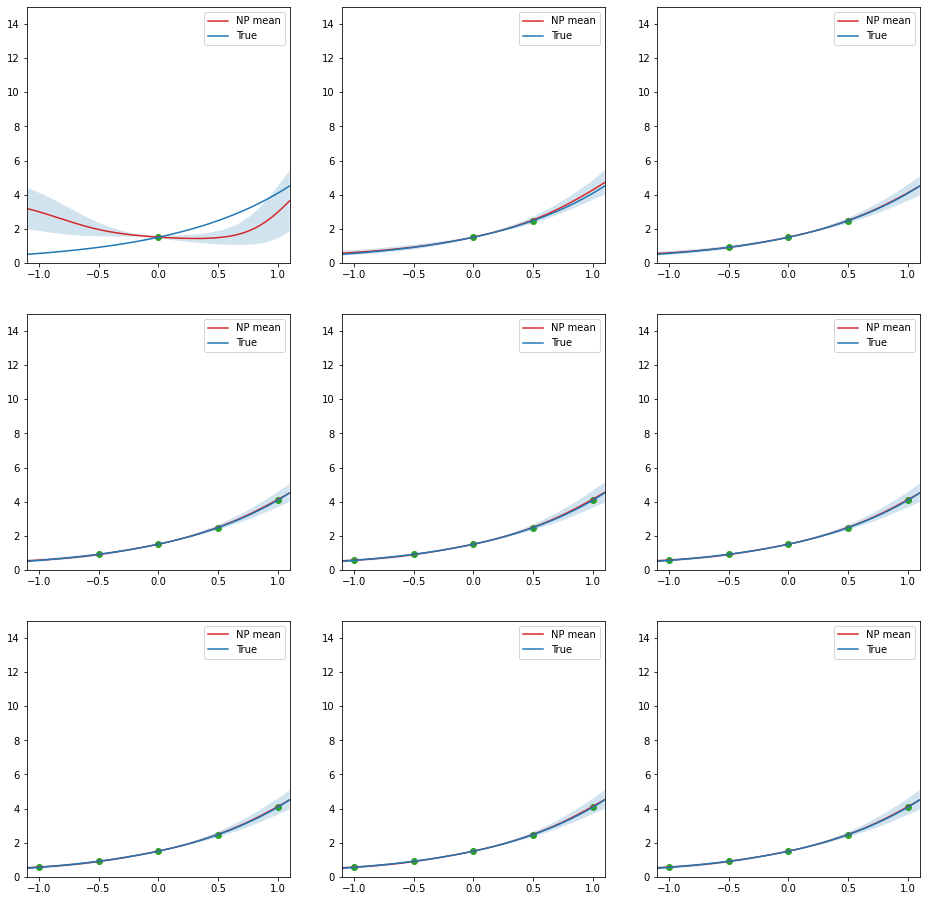

In [363]:
def plot_prediction(ax, context_xs, context_ys, func, kernel):
    input_xs= np.linspace(-1.1, 1.1, 200)
    pred_ys, z_mu, z_sigma = neurproc_exp(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()
    
    #for i in range(pred_ys.shape[0]):
    #    ax.plot(input_xs, pred_ys[i], c=ccycle[3], alpha=0.1)
        #ax.plot(input_xs, draw_gp_post(input_xs.reshape(-1, 1), context_xs.reshape(-1, 1), func_2, kernel), "b", alpha = 0.1)

    M = np.mean(pred_ys, axis = 0)
    S = np.std(pred_ys, axis = 0)

    ax.plot(input_xs, M, c=ccycle[3], label = "NP mean")
    ax.fill_between(input_xs.reshape(-1), M - 1.96*S, M + 1.96*S, "r", label = "_nolegend_", alpha = 0.2)
    ax.plot(all_xs, A*np.exp(all_xs*B), "-", label = "True")

    ax.scatter(context_xs, context_ys, c=ccycle[2])
    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((0, 15))
    ax.vlines(-3, -1.5, 1.5, alpha=.2)
    ax.vlines(3, -1.5, 1.5, alpha=.2)
    ax.legend()

max_n_context = 9
fig, axes = plt.subplots(3, 3, figsize=(16,16))
#all_context_xs = np.sort(np.random.uniform(-1, 1, max_n_context))
all_context_xs = np.array([0, 0.5, -0.5, 1, -1])
#A = np.random.uniform(low = 1, high = 2)
A = 1.5
#B = np.random.uniform(low = -2, high = 2)
B = 1
all_context_ys = (A*np.exp(B*all_context_xs.reshape(-1))).reshape(-1)
all_xs = np.linspace(-1, 1, 200)

for i in range(9):
    n_context = i + 1
    context_xs = all_context_xs[:n_context]
    context_ys = all_context_ys[:n_context]
    ax = axes[i // 3, i % 3]
    plot_prediction(ax, context_xs, context_ys, func, kernel)

In [373]:
all_context_xs = np.array([0, 0.5, -0.5, 1, -1]).reshape(-1, 1)
A = 1.5
B = 1

all_context_ys = ys = (A*np.exp(B*all_context_xs.reshape(-1))).reshape([-1,1]).astype(np.float32)
all_xs = np.linspace(-1, 1, 100)

M = np.zeros((5, len(all_xs)))
S = np.zeros((5, len(all_xs)))

for i in range(0, 5):
    context_xs = all_context_xs[:i+1]
    context_ys = all_context_ys[:i+1]
    input_xs = all_xs
    pred_ys, z_mu, z_sigma = neurproc_exp(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()

    Ms = np.mean(pred_ys, axis = 0).reshape(-1)
    Ss = np.std(pred_ys, axis = 0).reshape(-1)

    M[i,:] = Ms
    S[i, :] = Ss

In [378]:
np.save("expo_np_mean_fixedA", M)
np.save("expo_np_sd_fixedA", S)

In [386]:
# Training on exponential example

#Set up NN
params = NeuralProcessParams(
    dim_x=1,
    dim_y=1,
    dim_r=8,
    dim_z=4,
    n_hidden_units_h=[32, 32, 32],
    n_hidden_units_g=[32, 32, 32]
)

neurproc_exp2 = process.NeuralProcess(params)


# Strain settings
n_epochs = 1500
n_iter = 100
n_train_draws = 50
n_test_draws = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_loss = tf.keras.metrics.Mean(name='train_loss')

e_num = 0
#b_max = 1

for e in tqdm(range(n_epochs), desc="Training epochs"):

    train_loss.reset_states()

    zs = []
    for i in range(n_iter):
        # Select 20 random observations from a GP
        n_obs = 20
        xs = np.random.uniform(-1, 1, n_obs).reshape([-1, 1]).astype(np.float32)
        #amp = random.uniform(-2, 2)
        #ys = (amp * np.sin(xs)).astype(np.float32)
        A = np.random.uniform(low = 1, high = 2)
        #A = 1.5
        B = np.random.uniform(low = -2, high = 2)
        ys = (A*np.exp(B*xs.reshape(-1))).reshape([-1,1]).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)

        with tf.GradientTape() as tape:
            pred_ys_mu, z_mu, z_sigma, z_mu_ct, z_sigma_ct = neurproc_exp2(
                [context_xs], [context_ys], [target_xs], [target_ys], n_draws=n_train_draws
            )

            loglike_loss = tf.negative(loglikelihood(target_ys, pred_ys_mu))
            kl_loss = kullback_leibler_gaussian(z_mu, z_sigma, z_mu_ct, z_sigma_ct)
            loss = loglike_loss + kl_loss

        zs.append(z_mu.numpy())
        gradients = tape.gradient(loss, neurproc_exp2.trainable_variables)
        optimizer.apply_gradients(zip(gradients, neurproc_exp2.trainable_variables))

        train_loss(loss)
    
    print(f"Loss: {train_loss.result()}")

    if e_num == 500:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    if e_num == 1000:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6)
    
    if e_num == 0:
        neurproc_exp2.set_weights(neurproc_exp.get_weights()) 
    
    e_num = e_num + 1

4641418457
Loss: 25.50061798095703
Loss: 32.56892395019531
Loss: 12.574060440063477
Loss: 16.444202423095703
Loss: 25.012374877929688
Loss: 11.751380920410156
Loss: 28.93851089477539
Loss: 12.254053115844727
Loss: 37.062294006347656
Loss: 17.456340789794922
Loss: 20.624977111816406
Loss: 50.56565856933594
Loss: 27.275148391723633
Loss: 23.845260620117188
Loss: 25.66998291015625
Loss: 23.97913360595703
Loss: 23.465776443481445
Loss: 37.27150344848633
Loss: 20.82119369506836
Loss: 25.797842025756836
Loss: 24.216384887695312
Loss: 16.462600708007812
Loss: 26.750844955444336
Loss: 24.169282913208008
Loss: 22.532133102416992
Loss: 39.0485725402832
Loss: 25.311628341674805
Loss: 14.834356307983398
Loss: 18.34314727783203
Loss: 30.718896865844727
Loss: 25.754114151000977
Loss: 18.78583335876465
Loss: 41.37466812133789
Loss: 25.503232955932617
Loss: 26.607908248901367
Loss: 13.897565841674805
Loss: 42.6861572265625
Loss: 25.128829956054688
Loss: 13.573604583740234
Loss: 20.621679306030273
Loss

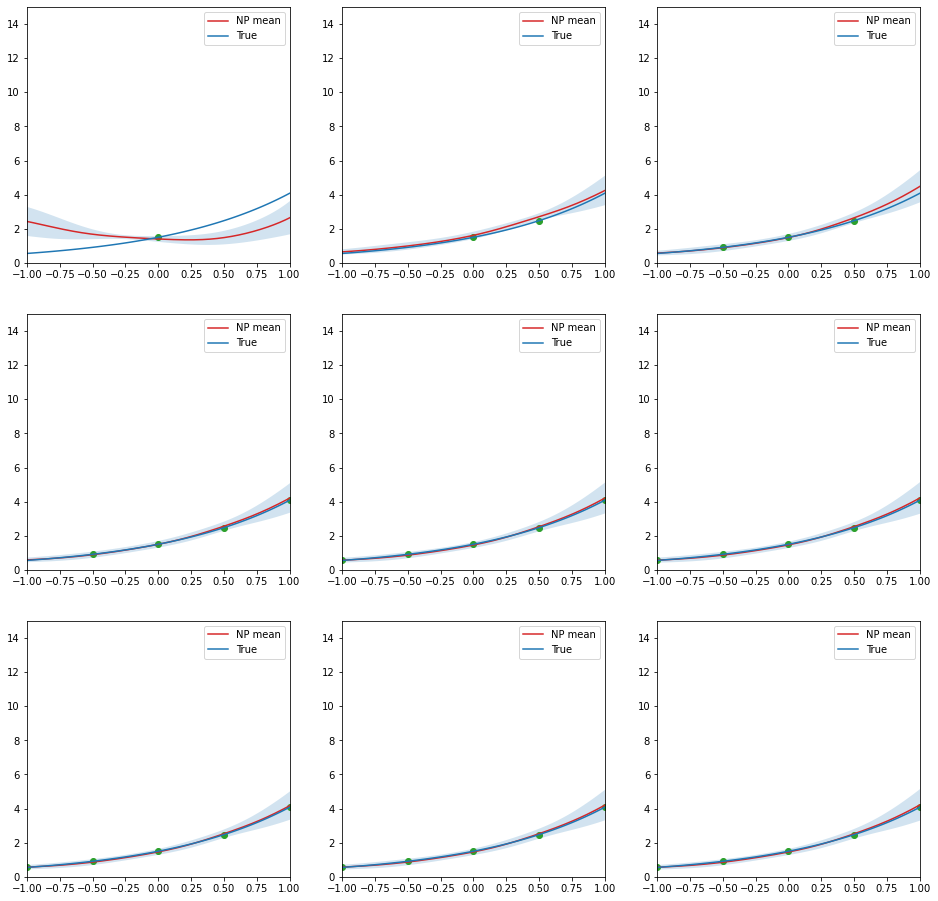

In [409]:
def plot_prediction(ax, context_xs, context_ys, func, kernel):
    input_xs= np.linspace(-1.1, 1.1, 200)
    pred_ys, z_mu, z_sigma = neurproc_exp2(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()
    
    #for i in range(pred_ys.shape[0]):
    #    ax.plot(input_xs, pred_ys[i], c=ccycle[3], alpha=0.1)
        #ax.plot(input_xs, draw_gp_post(input_xs.reshape(-1, 1), context_xs.reshape(-1, 1), func_2, kernel), "b", alpha = 0.1)

    M = np.mean(pred_ys, axis = 0)
    S = np.std(pred_ys, axis = 0)

    ax.plot(input_xs, M, c=ccycle[3], label = "NP mean")
    ax.fill_between(input_xs.reshape(-1), M - 1.96*S, M + 1.96*S, "r", label = "_nolegend_", alpha = 0.2)
    ax.plot(all_xs, A*np.exp(all_xs*B), "-", label = "True")

    ax.scatter(context_xs, context_ys, c=ccycle[2])
    ax.set_xlim((-1, 1))
    ax.set_ylim((0, 15))
    ax.vlines(-3, -1.5, 1.5, alpha=.2)
    ax.vlines(3, -1.5, 1.5, alpha=.2)
    ax.legend()

max_n_context = 9
fig, axes = plt.subplots(3, 3, figsize=(16,16))
#all_context_xs = np.random.uniform(-1, 1, max_n_context)
all_context_xs = np.array([0, 0.5, -0.5, 1, -1])
#A = np.random.uniform(low = 1, high = 2)
A = 1.5
#B = np.random.uniform(low = -2, high = 2)
B = 1
all_context_ys = (A*np.exp(B*all_context_xs.reshape(-1))).reshape(-1)
all_xs = np.linspace(-1, 1, 100)

for i in range(9):
    n_context = i + 1
    context_xs = all_context_xs[:n_context]
    context_ys = all_context_ys[:n_context]
    ax = axes[i // 3, i % 3]
    plot_prediction(ax, context_xs, context_ys, func, kernel)

In [410]:
all_context_xs = np.array([0, 0.5, -0.5, 1, -1]).reshape(-1, 1)
A = 1.5
B = 1

all_context_ys = ys = (A*np.exp(B*all_context_xs.reshape(-1))).reshape([-1,1]).astype(np.float32)
all_xs = np.linspace(-1, 1, 100)

M = np.zeros((5, len(all_xs)))
S = np.zeros((5, len(all_xs)))

for i in range(0, 5):
    context_xs = all_context_xs[:i+1]
    context_ys = all_context_ys[:i+1]
    input_xs = all_xs
    pred_ys, z_mu, z_sigma = neurproc_exp2(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()

    Ms = np.mean(pred_ys, axis = 0).reshape(-1)
    Ss = np.std(pred_ys, axis = 0).reshape(-1)

    M[i,:] = Ms
    S[i, :] = Ss

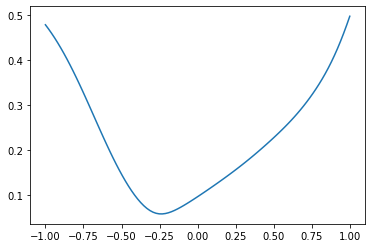

In [413]:
plt.plot(all_xs, S[0,:])

In [414]:
np.save("expo_np_mean_final", M)
np.save("expo_np_sd_final", S)

In [450]:
# Training on sin example, first only vary amplitude

#Set up NN
params = NeuralProcessParams(
    dim_x=1,
    dim_y=1,
    dim_r=8,
    dim_z=4,
    n_hidden_units_h=[32, 32, 32],
    n_hidden_units_g=[32, 32, 32]
)

neurproc_sin1 = process.NeuralProcess(params)

# Strain settings
n_epochs = 500
n_iter = 100
n_train_draws = 50
n_test_draws = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
train_loss = tf.keras.metrics.Mean(name='train_loss')

e_num = 0
#b_max = 1

for e in tqdm(range(n_epochs), desc="Training epochs"):

    train_loss.reset_states()

    zs = []
    for i in range(n_iter):
        # Select 20 random observations from a GP
        n_obs = 20
        xs = np.random.uniform(-5, 5, n_obs).reshape([-1, 1]).astype(np.float32)
        amp = random.uniform(-1, 1)
        #ys = (amp * np.sin(xs)).astype(np.float32)
        ys = amp*np.sin(xs.reshape(-1)).reshape([-1,1]).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)

        with tf.GradientTape() as tape:
            pred_ys_mu, z_mu, z_sigma, z_mu_ct, z_sigma_ct = neurproc_sin1(
                [context_xs], [context_ys], [target_xs], [target_ys], n_draws=n_train_draws
            )

            loglike_loss = tf.negative(loglikelihood(target_ys, pred_ys_mu))
            kl_loss = kullback_leibler_gaussian(z_mu, z_sigma, z_mu_ct, z_sigma_ct)
            loss = loglike_loss + kl_loss

        zs.append(z_mu.numpy())
        gradients = tape.gradient(loss, neurproc_sin1.trainable_variables)
        optimizer.apply_gradients(zip(gradients, neurproc_sin1.trainable_variables))

        train_loss(loss)
    
    print(f"Loss: {train_loss.result()}")

    if e_num == 10:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    if e_num == 400:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    e_num = e_num + 1


Loss: 37382808141824.0
Loss: 1031955.75
Loss: 730754.25
Loss: 682952.0
Loss: 708679.625
Loss: 683746.875
Loss: 700603.0625
Loss: 498629.5625
Loss: 554582.0625
Loss: 565389.25
Loss: 480028.8125
Loss: 9125.5009765625
Loss: 767.4865112304688
Loss: 347.963134765625
Loss: 200.27044677734375
Loss: 151.802490234375
Loss: 126.39254760742188
Loss: 90.02674865722656
Loss: 82.69677734375
Loss: 50.553768157958984
Loss: 59.23704528808594
Loss: 54.526092529296875
Loss: 46.78961944580078
Loss: 34.954952239990234
Loss: 32.72267150878906
Loss: 35.84943771362305
Loss: 33.80550765991211
Loss: 29.154611587524414
Loss: 26.55011749267578
Loss: 30.814245223999023
Loss: 29.180288314819336
Loss: 20.809885025024414
Loss: 23.89223861694336
Loss: 19.518766403198242
Loss: 23.474952697753906
Loss: 20.581083297729492
Loss: 19.656028747558594
Loss: 24.073196411132812
Loss: 18.73795509338379
Loss: 20.878742218017578
Loss: 18.866222381591797
Loss: 17.33147621154785
Loss: 16.48857879638672
Loss: 21.002696990966797
Loss:

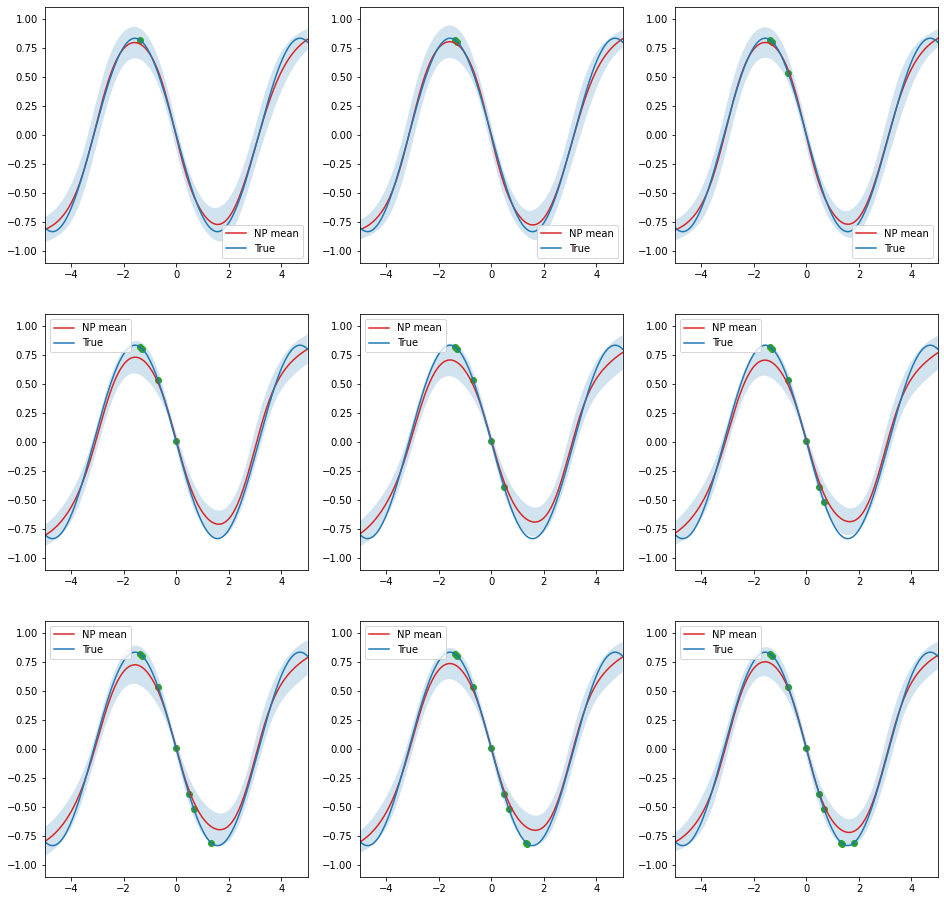

In [461]:
def plot_prediction(ax, context_xs, context_ys, func, kernel):
    input_xs= np.linspace(-5, 5, 200)
    pred_ys, z_mu, z_sigma = neurproc_sin1(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()
    
    #for i in range(pred_ys.shape[0]):
    #    ax.plot(input_xs, pred_ys[i], c=ccycle[3], alpha=0.1)
        #ax.plot(input_xs, draw_gp_post(input_xs.reshape(-1, 1), context_xs.reshape(-1, 1), func_2, kernel), "b", alpha = 0.1)

    M = np.mean(pred_ys, axis = 0)
    S = np.std(pred_ys, axis = 0)

    ax.plot(input_xs, M, c=ccycle[3], label = "NP mean")
    ax.fill_between(input_xs.reshape(-1), M - 1.96*S, M + 1.96*S, "r", label = "_nolegend_", alpha = 0.2)
    ax.plot(all_xs, a*np.sin(input_xs.reshape(-1)), "-", label = "True")

    ax.scatter(context_xs, context_ys, c=ccycle[2])
    ax.set_xlim((-5, 5))
    ax.set_ylim((-1.1, 1.1))
    ax.legend()

max_n_context = 9
fig, axes = plt.subplots(3, 3, figsize=(16,16))
all_context_xs = np.sort(np.random.uniform(-2, 2, max_n_context))
a = np.random.uniform(low = -1, high = 1)
all_context_ys = a*np.sin(all_context_xs.reshape(-1)).reshape(-1)

for i in range(9):
    n_context = i + 1
    context_xs = all_context_xs[:n_context]
    context_ys = all_context_ys[:n_context]
    ax = axes[i // 3, i % 3]
    plot_prediction(ax, context_xs, context_ys, func, kernel)

In [464]:
# Training on sin example, now vary phase

#Set up NN
params = NeuralProcessParams(
    dim_x=1,
    dim_y=1,
    dim_r=8,
    dim_z=4,
    n_hidden_units_h=[32, 32, 32],
    n_hidden_units_g=[32, 32, 32]
)

neurproc_sin2 = process.NeuralProcess(params)

# Strain settings
n_epochs = 1500
n_iter = 100
n_train_draws = 50
n_test_draws = 200

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
train_loss = tf.keras.metrics.Mean(name='train_loss')

e_num = 0
#b_max = 1

for e in tqdm(range(n_epochs), desc="Training epochs"):

    train_loss.reset_states()

    zs = []
    for i in range(n_iter):
        # Select 20 random observations from a GP
        n_obs = 20
        xs = np.random.uniform(-5, 5, n_obs).reshape([-1, 1]).astype(np.float32)
        amp = random.uniform(0, 1)
        phi = random.uniform(0, np.pi)
        #ys = (amp * np.sin(xs)).astype(np.float32)
        ys = amp*np.sin(xs.reshape(-1) - phi).reshape([-1,1]).astype(np.float32)

        # Random number of context points
        n_context = random.choice(range(1, 11))
        context_xs, context_ys, target_xs, target_ys = split_context_target(xs, ys, n_context)

        with tf.GradientTape() as tape:
            pred_ys_mu, z_mu, z_sigma, z_mu_ct, z_sigma_ct = neurproc_sin2(
                [context_xs], [context_ys], [target_xs], [target_ys], n_draws=n_train_draws
            )

            loglike_loss = tf.negative(loglikelihood(target_ys, pred_ys_mu))
            kl_loss = kullback_leibler_gaussian(z_mu, z_sigma, z_mu_ct, z_sigma_ct)
            loss = loglike_loss + kl_loss

        zs.append(z_mu.numpy())
        gradients = tape.gradient(loss, neurproc_sin2.trainable_variables)
        optimizer.apply_gradients(zip(gradients, neurproc_sin2.trainable_variables))

        train_loss(loss)
    
    print(f"Loss: {train_loss.result()}")
    
    if e_num == 500:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    if e_num == 1000:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    
    if e_num == 0:
        neurproc_sin2.set_weights(neurproc_sin1.get_weights()) 
    
    e_num = e_num + 1

Loss: -1.0215644836425781
Loss: -1.1310608386993408
Loss: -0.815798282623291
Loss: -2.085526704788208
Loss: -1.0794000625610352
Loss: -1.8710970878601074
Loss: -1.2015132904052734
Loss: -1.2113137245178223
Loss: -1.1942774057388306
Loss: 0.2517612874507904
Loss: -2.0735392570495605
Loss: -1.5310598611831665
Loss: -2.4032654762268066
Loss: -1.7887078523635864
Loss: -1.3628698587417603
Loss: -2.035670280456543
Loss: -1.6633763313293457
Loss: -2.4550817012786865
Loss: -1.5131586790084839
Loss: -1.476996898651123
Loss: -1.0040173530578613
Loss: -2.7643823623657227
Loss: -2.1609106063842773
Loss: -1.6217446327209473
Loss: -0.9615120887756348
Loss: -0.727333128452301
Loss: -1.7060006856918335
Loss: -1.9678438901901245
Loss: -1.888710379600525
Loss: -0.03868678957223892
Loss: -1.2195079326629639
Loss: -1.138447642326355
Loss: -1.0300605297088623
Loss: -1.909064769744873
Loss: -2.6876273155212402
Loss: -0.531517505645752
Loss: -0.8504900932312012
Loss: -1.647817850112915
Loss: -2.3658626079559

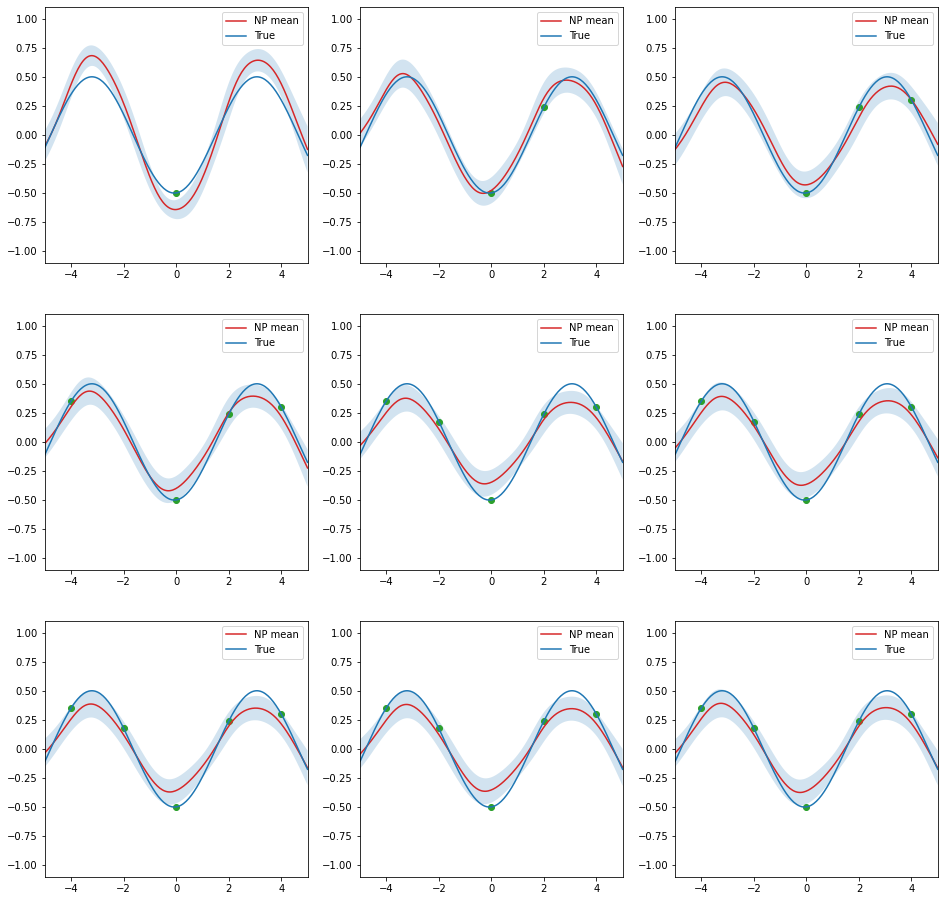

In [478]:
def plot_prediction(ax, context_xs, context_ys, func, kernel):
    input_xs= np.linspace(-5, 5, 200)
    pred_ys, z_mu, z_sigma = neurproc_sin2(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()
    
    #for i in range(pred_ys.shape[0]):
    #    ax.plot(input_xs, pred_ys[i], c=ccycle[3], alpha=0.1)
        #ax.plot(input_xs, draw_gp_post(input_xs.reshape(-1, 1), context_xs.reshape(-1, 1), func_2, kernel), "b", alpha = 0.1)

    M = np.mean(pred_ys, axis = 0)
    S = np.std(pred_ys, axis = 0)

    ax.plot(input_xs, M, c=ccycle[3], label = "NP mean")
    ax.fill_between(input_xs.reshape(-1), M - S, M + S, "r", label = "_nolegend_", alpha = 0.2)
    ax.plot(all_xs, a*np.sin(input_xs.reshape(-1)-phi), "-", label = "True")

    ax.scatter(context_xs, context_ys, c=ccycle[2])
    ax.set_xlim((-5, 5))
    ax.set_ylim((-1.1, 1.1))
    ax.legend()

max_n_context = 9
fig, axes = plt.subplots(3, 3, figsize=(16,16))
all_context_xs = np.random.uniform(-5, 5, max_n_context)

all_context_xs = np.array([0, 2, 4, -4, -2])
#a = np.random.uniform(low = 0, high = 1)
#phi = np.random.uniform(low = 0, high = np.pi)
a = 0.5
phi = 1.5

all_context_ys = a*np.sin(all_context_xs.reshape(-1)-phi)

for i in range(9):
    n_context = i + 1
    context_xs = all_context_xs[:n_context]
    context_ys = all_context_ys[:n_context]
    ax = axes[i // 3, i % 3]
    plot_prediction(ax, context_xs, context_ys, func, kernel)

In [484]:
all_context_xs = np.array([0, 2, -2, 4, -4]).reshape(-1, 1)
a = 0.5
phi = 1.5

all_context_ys = (a*np.sin(all_context_xs.reshape(-1) - phi)).reshape([-1,1]).astype(np.float32)
xs = np.linspace(-5, 5, 250)

M = np.zeros((5, len(all_xs)))
S = np.zeros((5, len(all_xs)))

for i in range(0, 5):
    context_xs = all_context_xs[:i+1]
    context_ys = all_context_ys[:i+1]
    input_xs = all_xs
    pred_ys, z_mu, z_sigma = neurproc_sin2(
        [context_xs.reshape((-1,1)).astype(np.float32)],
        [context_ys.reshape((-1,1)).astype(np.float32)],
        [input_xs.reshape((-1,1)).astype(np.float32)],
        n_draws=250
    )
    pred_ys = tf.squeeze(pred_ys).numpy()

    Ms = np.mean(pred_ys, axis = 0).reshape(-1)
    Ss = np.std(pred_ys, axis = 0).reshape(-1)

    M[i,:] = Ms
    S[i, :] = Ss

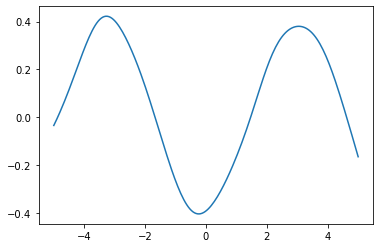

In [487]:
plt.plot(input_xs, M[2,:])

In [488]:
np.save("sine_np_mean_final", M)
np.save("sine_np_sd_final", S)